## Fake News Detection

Import libraries

In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk import word_tokenize, WordPunctTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import PolynomialFeatures,OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [72]:
train = pd.read_csv('../data/fake_or_real_news_training.csv')
# the submission data has no label
submission = pd.read_csv('../data/fake_or_real_news_test.csv')

First look at data

In [73]:
train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


We can see that two extra columns were created, X1 and X2. This is due to the fact that the title is not in quotes such that, if there is a comma in the title, it get's separated at that point and all the other column get shifted. The following cell will take care of that

In [74]:
def rearrange(df):
    for row in range(len(df)):
        if not pd.isna(df.iloc[row, 5]):
            # Concatenate according columns
            df.iloc[row, 1] = df.iloc[row, 1] + df.iloc[row, 2] + df.iloc[row, 3]
            df.iloc[row, 2] = df.iloc[row, 4]
            df.iloc[row, 3] = df.iloc[row, 5]
        elif not pd.isna(df.iloc[row, 4]):
            df.iloc[row, 1] = df.iloc[row, 1] + df.iloc[row, 2]
            df.iloc[row, 2] = df.iloc[row, 3]
            df.iloc[row, 3] = df.iloc[row, 4]
    df = df.drop(['X1', 'X2'], axis = 1)
    return df

train = rearrange(train)

In [75]:
train.head()

,ID,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


### EDA

Proportion of fake-news:

In [76]:
len(train.loc[train['label'] == 'FAKE'])/len(train)

0.4978744686171543

Explore phrase length

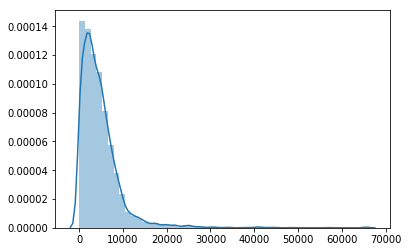

In [77]:
text_len = pd.DataFrame([len(t) for t in train.text])
sns.distplot(text_len)

The distribution is highly skewed to the right.

### Baseline

Run a baseline without further preprocessing using the countvectorizer, using the text only

Split data into train and test set

In [108]:
X_baseline, X_test_baseline, y_baseline, y_test_baseline = train_test_split(train['text'], train['label'],
                                                                            test_size = 0.2, random_state = 7)

Count-vectorize data:

In [110]:
# Initiaulize countvectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform 
count_train = count_vectorizer.fit_transform(X_baseline) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test_baseline)

Use Naive Bayes for a first classification

In [114]:
MltNB = MultinomialNB() 

In [123]:
MltNB.fit(count_train, y_baseline)
pred = MltNB.predict(count_test)
acc = accuracy_score(y_test_baseline, pred)
print("accuracy:   %0.3f" % acc)

confusion_matrix(y_test_baseline, pred, labels=[0, 1])

accuracy:   0.895


array([[348,  57],
       [ 27, 368]])

#### Define functions for further use

In [78]:
stopwords_en = stopwords.words('english')
# define function to eliminate the stopwords
def eliminate_stopwords(wordslist):
    """
    stopwords_en is predefined outside of the function
    """
    wordslist = [i for i in wordslist if i.isalpha()]
    clean_list = [i for i in wordslist if i not in stopwords_en]
    return clean_list

In [79]:
# postag
def count_postags(words):
    tagged_words = nltk.pos_tag(words)
    num_noun = 0
    num_verb = 0
    num_adj = 0
    for word in tagged_words:
        if word[1] == 'NN':
            num_noun += 1
        elif word[1] == 'VERB':
            num_verb += 1
        elif word[1] == 'ADJ':
            num_adj += 1
    return num_noun, num_verb, num_adj


In [80]:
# detect keywords
def detect_keyword(words, keyword):
    if keyword in words:
        return 1
    else:
        return 0

I don't think this is needed anymore, please check, Scott

In [81]:
# since the training set has 33 rows of data in the wrong format
# we are going to simply remove the rows
print(len(train.label.unique()))
#train = train[(train.label == 'REAL')|(train.label == 'FAKE')]

2


In [82]:
data_test = train.copy()

In [83]:
data_test['title_token'] = data_test.title.apply(lambda x:word_tokenize(x.lower()))
data_test.head()

,ID,title,text,label,title_token
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,"[you, can, smell, hillary, ’, s, fear]"
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,"[watch, the, exact, moment, paul, ryan, commit..."
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,"[kerry, to, go, to, paris, in, gesture, of, sy..."
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,"[bernie, supporters, on, twitter, erupt, in, a..."
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,"[the, battle, of, new, york, :, why, this, pri..."


In [85]:
def prepare_data(data):
    """
    preprocessing + feature engineering
    """
    # tokenize the title and text
    data['title_token'] = data.title.apply(lambda x:word_tokenize(x.lower()))
    data['text_token'] = data.text.apply(lambda x:word_tokenize(x.lower()))
    # convert the target variable to 0 and 1
    data.label = data.label.apply(lambda x:1 if x == 'REAL' else 0)
    
    # eliminate the stopwords in title and text
    data['titletoken_without_stopwords'] = data.title_token.apply(lambda x:eliminate_stopwords(x))
    data['texttoken_without_stopwords'] = data.text_token.apply(lambda x:eliminate_stopwords(x))
    # drop the redundent features
    data = data.drop(['text','title'],axis=1)
    # need to eliminate the punctuation as well? 
    # maybe do it with regex from the original title and text

    ## feature engineering 
    
    # find keywords
    data['trump_title'] = data.titletoken_without_stopwords.apply(lambda x:detect_keyword(x,'trump'))
    data['trump_text'] = data.texttoken_without_stopwords.apply(lambda x:detect_keyword(x,'trump'))
    
    # count the postags
    # title
    data['title_postags'] = data.titletoken_without_stopwords.apply(lambda x:count_postags(x))
    data['title_NN_count'] = data.title_postags.map(lambda x:x[0])
    data['title_VERB_count'] = data.title_postags.map(lambda x:x[1])
    data['title_ADJ_count'] = data.title_postags.map(lambda x:x[2])
    # text
    data['text_postags'] = data.texttoken_without_stopwords.apply(lambda x:count_postags(x))
    data['text_NN_count'] = data.text_postags.map(lambda x:x[0])
    data['text_VERB_count'] = data.text_postags.map(lambda x:x[1])
    data['text_ADJ_count'] = data.text_postags.map(lambda x:x[2])
    
    
    
    # create new features describe the length of the title and text, counting by words
    # also maybe try with counting by letters
    # and shall treat them as categorical variables group up with factor levels 
    data['title_length'] = data.title_token.apply(lambda x:len(x))
    data['text_length'] = data.text_token.apply(lambda x:len(x))
    # also highlight the keywords maybe?
    
    
    
    return data

In [86]:
train_df = prepare_data(train)

In [89]:
def splitdata(data, cols):
    """
    cols: a list of columns names to use
    """
    features = data[cols]
    target = data.label
    # first split into (train+test) and for holdout
    TrainingSetX, X_holdout, TrainingSetY, y_holdout = train_test_split(features, target, 
                                                    test_size=0.10, stratify=target, 
                                                    random_state=666)
    # split (train+test) into train and test
    X_train, X_test, y_train, y_test = train_test_split(TrainingSetX, TrainingSetY, 
                                                test_size=0.20, stratify=TrainingSetY, 
                                                random_state=666)
    # train and test use for modeling, holdout use for validating the model
    print("spliting the data......")
    print("shape of train set: ", X_train.shape)
    print("shape of test set: ", X_test.shape)
    print("shape of holdout set: ", X_holdout.shape)
    
    return X_train, y_train, X_test, y_test, X_holdout, y_holdout

In [31]:
cols2model = ['title_token', 'text_token', 'titletoken_without_stopwords', 
              'texttoken_without_stopwords', 'title_length']
x1,y1,x2,y2,x3,y3 = splitdata(train_df, cols = cols2model)

spliting the data......
shape of train set:  (2879, 5)
shape of test set:  (720, 5)
shape of holdout set:  (400, 5)


In [34]:
# random forest classifier
def model_rf(data,cols2model):
    # split data
    X_train, y_train, X_test, y_test, X_holdout, y_holdout = splitdata(train_df, cols = cols2model)
    print('features for modeling :',X_train.columns.tolist())
    # identify the categorical features and the numerical features
    categorical_features = X_train.dtypes == 'category'
    numerical_features = ~categorical_features
    # pipeline
    print('building up pipeline......')
    estimators = [   
                    ('ctf',ColumnTransformer([
                                ('scale',StandardScaler(),
                                         numerical_features),
                                ('enc',OneHotEncoder(categories='auto',handle_unknown='ignore'),
                                         categorical_features),
                                            ])
                    ),
#                     ('poly', PolynomialFeatures(degree=1, include_bias=False, interaction_only=True)),
                    ('RF',RandomForestClassifier(random_state=666,n_estimators=170,max_depth=22,n_jobs=-1))
                ]
    pipe = Pipeline(estimators)
    
    print('training the model......')
    model = pipe.fit(X_train,y_train)
    
    print('training is done')
    score_train = model.score(X_train,y_train) 
    score_test = model.score(X_test,y_test) 
    score_Holdout = model.score(X_holdout,y_holdout) 
    
    print('training dataset mode1 is: %s'%(str(score_train1)))   
    print('test dataset model is: %s'%(str(score_test1)))
    print('Holdout dataset model1 is: %s'%(str(score_H1)))
    
    # in case needs to use the data to do some visualization or some other metrics
    data_pack = (X_train, y_train, X_test, y_test, X_holdout, y_holdout)
    return model, data_pack

In [7]:
sample = train.copy()

In [11]:
try_text = 'this is a Sentence.'
result = word_tokenize(try_text.lower())
print(result)


['this', 'is', 'a', 'sentence', '.']
this is a sentence.


In [ ]:
sample['text_try'] = sample.text.apply(lambda x:word_tokenize(x))